# IEEE For Fraud Detection

## Reference
- https://medium.com/@mr.priyankmishra/a-realistic-approach-to-ieee-cis-fraud-detection-25faea54137
- https://www.kaggle.com/competitions/ieee-fraud-detection/data

The datasets provided by the Competiton Host are as follows,

- **train_transaction.csv** : The transaction dataset comprising the transaction details to be used for training the model.
- **train_identity.csv** : The identity dataset comprising the additional details about the identity of the payer and the merchant between whom the transaction was performed and the details of transactions are present in the train_transaction.csv.
- **test_transaction.csv** : The transaction dataset comprising the transaction information to test the performance of the trained model.
- **test_identity.csv** : The identity dataset comprising the additional identity information about the transactions present in the test_transaction.


## Description of Transaction Dataset

- **TransactionID** — Id of the transaction and is the foreign key in the Identity Dataset.
- **isFraud** — 0 or 1 signifying whether a transaction is fraudulent or not.
- **TransactionDT** — timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt** — Transaction Payment Amount in USD.
- **ProductCD** — Product Code.
- **card1 — card6** — Payment Card information, such as card type, card category, issue bank, country, etc.
- **addr** — Address
- **dist** — Distance
- **P_emaildomain** — Purchaser Email Domain.
- **R_emaildomain** — Receiver Email Domain.
- **C1-C14** — counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- **D1-D15** — timedelta, such as days between previous transactions, etc.
- **M1-M9** — match, such as names on card and address, etc.
- **V1-V339** — Vesta engineered rich features, including ranking, counting, and other entity relations.


Following Features are Categorical in the Transaction Dataset,


- **ProductCD**
- **card1-card6**
- **addr1, addr2**
- **P_emaildomain**
- **R_emaildomain**
- **M1-M9**

Description of the Identity Dataset

Following Features are present in the Identity Dataset,

- **TransactionID** — Foreign key to the Transaction Dataset.
- **id_01-id_38** — Masked features corresponding to the identity of the card holders.
- **DeviceType** — Type of Device used to make the Transaction.
- **DeviceInfo** — Information regarding the characteristics of the Device.


Following Features are Categorical in the Identity Dataset,


- **DeviceType**
- **DeviceInfo**
- **id_12 — id_38**


Variables in this table are identity information — network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They’re collected by Vesta’s fraud protection system and digital security partners.


(The field names are masked and a pairwise dictionary is not provided for privacy protection and contract agreement).

## Node and Edge Definitions for DGL Graph


#### **Node Features** (Entity Properties)

#### **Card Nodes:**
- `card1-card6` (payment card information)
- `addr1, addr2` (addresses associated with cards)
- Aggregated transaction statistics per card (mean/sum TransactionAMT, transaction frequency, etc.)

#### **Email Domain Nodes:**
- `P_emaildomain, R_emaildomain` (purchaser/receiver email domains)
- Domain-level aggregated features (transaction volume, fraud rates)

#### **Device Nodes:**
- `DeviceType, DeviceInfo`
- `id_01-id_38` (masked identity features - these likely contain device fingerprinting info)

#### **User/Identity Nodes:**
- Identity-related features from the identity dataset
- Behavioral patterns aggregated at user level

### **Edge Features** (Transaction Properties)

#### **Transaction Edges** (connecting relevant entities):
- `TransactionAMT` (transaction amount)
- `TransactionDT` (time delta)
- `ProductCD` (product code)
- `C1-C14` (counting features - relationships between entities)
- `D1-D15` (time deltas between transactions)
- `M1-M9` (matching features between entities)
- `V1-V339` (Vesta's engineered relationship features)
- `dist` (distance features)

### **Graph Structure Recommendations:**

1. **Card ↔ Transaction ↔ Email Domain**: Connect cards to email domains through transaction edges
2. **Card ↔ Device**: When the same card is used on multiple devices
3. **Email Domain ↔ Device**: When the same email is used across devices
4. **Temporal Edges**: Connect sequential transactions from the same entity

### **Hybrid Approach:**

Since you're combining GNN + XGBoost:

- **GNN Component**: Use the graph structure to learn entity embeddings and relationship patterns
- **XGBoost Component**: Use both:
  - Original tabular features (transaction-level)
  - GNN-generated embeddings as additional features

The `V1-V339` features are particularly valuable as they're already engineered relationship features from Vesta, making them perfect candidates for both edge features and XGBoost input.

This structure allows the GNN to capture network effects (like cards frequently transacting with suspicious email domains) while XGBoost handles the complex non-linear patterns in the tabular data.


In [1]:
# Check if CUDA is available. Change Runtime to TPU

!nvidia-smi

Wed Sep 17 12:16:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# https://pytorch.org/get-started/previous-versions/
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [3]:

# Install DGL for Cuda 12.4, torch 2.4.x
# https://www.dgl.ai/pages/start.html
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 3.0 MB/s eta 0:00:00


In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.stats as st
from collections import Counter
from typing import List, Tuple, Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    confusion_matrix, classification_report, f1_score
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
root_path = "./machine-learning/gnns-dgl/datasets/ieee-fraud-detection/"
!ls {root_path}

transaction_path = os.path.join(root_path, "train_transaction.csv")
identity_path = os.path.join(root_path, "train_identity.csv")

sample_submission.csv  test_transaction.csv  train_transaction.csv
test_identity.csv      train_identity.csv


In [3]:
def load_chunk(file_path, chunk_size = 5):
  csv_chunks = pd.read_csv(file_path, chunksize=chunk_size)
  for i, chunk in enumerate(csv_chunks):
    return chunk

In [4]:
load_chunk(transaction_path, chunk_size = 5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
load_chunk(identity_path, chunk_size = 100)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.000000,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.000000,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.000000,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.000000,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.000000,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [20]:
# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def compare_balanced_vs_unbalanced(X_val, y_val, balanced_model, unbalanced_model):
    """Compare balanced vs unbalanced training approaches"""
    print("Comparing balanced vs unbalanced approaches...")

    # Predictions
    y_pred_unbalanced = unbalanced_model.predict_proba(X_val)[:, 1]
    y_pred_balanced   = balanced_model.predict_proba(X_val)[:, 1]

    # Metrics
    auc_unbalanced = roc_auc_score(y_val, y_pred_unbalanced)
    auc_balanced = roc_auc_score(y_val, y_pred_balanced)

    ap_unbalanced = average_precision_score(y_val, y_pred_unbalanced)
    ap_balanced = average_precision_score(y_val, y_pred_balanced)

    print(f"Unbalanced Model:")
    print(f"  AUC: {auc_unbalanced:.4f}")
    print(f"  Average Precision: {ap_unbalanced:.4f}")

    print(f"\nBalanced Model:")
    print(f"  AUC: {auc_balanced:.4f}")
    print(f"  Average Precision: {ap_balanced:.4f}")

    print(f"\nImprovement:")
    print(f"  AUC: {auc_balanced - auc_unbalanced:+.4f}")
    print(f"  Average Precision: {ap_balanced - ap_unbalanced:+.4f} ({((ap_balanced/ap_unbalanced)-1)*100:+.1f}%)")

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Precision-Recall curves
    precision_unb, recall_unb, _ = precision_recall_curve(y_val, y_pred_unbalanced)
    precision_bal, recall_bal, _ = precision_recall_curve(y_val, y_pred_balanced)

    axes[0].plot(recall_unb, precision_unb, linewidth=2, label=f'Unbalanced (AP = {ap_unbalanced:.3f})')
    axes[0].plot(recall_bal, precision_bal, linewidth=2, label=f'Balanced (AP = {ap_balanced:.3f})')
    axes[0].axhline(y=y_val.mean(), color='r', linestyle='--', label=f'Baseline = {y_val.mean():.3f}')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title('Precision-Recall Curve Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ROC curves
    fpr_unb, tpr_unb, _ = roc_curve(y_val, y_pred_unbalanced)
    fpr_bal, tpr_bal, _ = roc_curve(y_val, y_pred_balanced)

    axes[1].plot(fpr_unb, tpr_unb, linewidth=2, label=f'Unbalanced (AUC = {auc_unbalanced:.3f})')
    axes[1].plot(fpr_bal, tpr_bal, linewidth=2, label=f'Balanced (AUC = {auc_balanced:.3f})')
    axes[1].plot([0, 1], [0, 1], 'r--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Spearman correlation between predictions
    rho, p = st.spearmanr(y_pred_unbalanced, y_pred_balanced)
    print(f"Spearman correlation between balanced and unbalanced predictions: {rho:.4f}")

    return {
        'unbalanced': {'auc': auc_unbalanced, 'ap': ap_unbalanced},
        'balanced': {'auc': auc_balanced, 'ap': ap_balanced}
    }

class XGBoostOnlyPipeline:
    """
    Pure XGBoost pipeline using only numerical features.

    Excludes all identifier features (card*, addr*, emails, device info, etc.)
    and focuses purely on behavioral/transactional patterns.

    Features used:
    - TransactionAmt, TransactionDT (core transaction info)
    - C1-C14 (counting features)
    - D1-D15 (time delta features)
    - V1-V339 (Vesta engineered features)
    - id_01-id_11 (numerical identity features only, excludes categorical id_12-id_38)
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.df = None
        self.train_indices = None
        self.val_indices = None
        self.feature_names = []

    def load_and_preprocess_data(self, transaction_path: str, identity_path: str) -> pd.DataFrame:
        """
        Load IEEE fraud detection dataset and perform basic preprocessing.

        Args:
            transaction_path: Path to train_transaction.csv
            identity_path: Path to train_identity.csv

        Returns:
            Merged and preprocessed DataFrame
        """
        print("=== LOADING IEEE FRAUD DETECTION DATA ===")

        # Load datasets
        print("Loading transaction data...")
        train_transaction = pd.read_csv(transaction_path)
        print(f"  Transaction records: {len(train_transaction):,}")

        print("Loading identity data...")
        train_identity = pd.read_csv(identity_path)
        print(f"  Identity records: {len(train_identity):,}")

        # Merge datasets
        self.df = train_transaction.merge(train_identity, on='TransactionID', how='left')
        print(f"  Merged dataset: {self.df.shape}")

        # Basic preprocessing
        self._preprocess_features()

        # Show class distribution
        fraud_count = (self.df['isFraud'] == 1).sum()
        fraud_rate = fraud_count / len(self.df)
        print(f"\nClass Distribution:")
        print(f"  Total transactions: {len(self.df):,}")
        print(f"  Fraudulent: {fraud_count:,} ({fraud_rate:.2%})")
        print(f"  Legitimate: {len(self.df) - fraud_count:,} ({1-fraud_rate:.2%})")

        return self.df

    def _preprocess_features(self):
        """
        Preprocess features focusing only on numerical/behavioral patterns.

        Key principle: Only use features that represent transaction behavior,
        not entity identifiers that could cause overfitting or data leakage.
        """
        print("Preprocessing features...")

        # Define numerical features to keep (behavioral patterns only)
        self.numerical_features = (
            # ['TransactionAmt', 'TransactionDT'] +                 # Core transaction info
            ['TransactionAmt'] +                                    # Core transaction info without Transaction Date Delta as we don't know what's used to calculate it
            [f'C{i}' for i in range(1, 15)] +                       # Counting features
            [f'D{i}' for i in range(1, 16)] +                       # Time delta features
            [f'V{i}' for i in range(1, 340)]                       # Vesta engineered features
        )

        self.categorical_features = (
            ['ProductCD', "DeviceType", "DeviceInfo"] +               # Product Code and other categorical features
            # [f'id_{i:02d}' for i in range(1, 12)] +                 # Masked features corresponding to the identity of the card holders.
            [f'card{i}' for i in range(1, 7)]                         # Payment Card categorical information, such as card type, card category, issue bank, country, etc.
        )

        selected_features = self.numerical_features + self.categorical_features

        # Keep only features that exist in the dataset
        self.feature_names = [col for col in selected_features if col in self.df.columns]

        print(f"  Selected {len(self.feature_names)} numerical features")
        print(f"    TransactionAmt, TransactionDT: 2 features")
        print(f"    C features: {len([f for f in self.feature_names if f.startswith('C')])}")
        print(f"    D features: {len([f for f in self.feature_names if f.startswith('D')])}")
        print(f"    V features: {len([f for f in self.feature_names if f.startswith('V')])}")
        print(f"    id features: {len([f for f in self.feature_names if f.startswith('id_')])}")

        print("Feature preprocessing completed")

    def split_data(self, test_size: float = 0.2, random_state: int = RANDOM_STATE) -> Tuple[np.ndarray, np.ndarray]:
        """
        Split data into train/validation sets using stratified sampling.

        Args:
            test_size: Proportion of data for validation
            random_state: Random seed for reproducibility

        Returns:
            Tuple of (train_indices, val_indices)
        """
        print(f"\n=== SPLITTING DATA (train: {1-test_size:.0%}, val: {test_size:.0%}) ===")

        # Stratified split to maintain fraud rate in both sets
        indices = np.arange(len(self.df))
        train_idx, val_idx = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=self.df['isFraud']
        )

        self.train_indices = train_idx
        self.val_indices = val_idx

        # Verify split quality
        train_fraud_rate = self.df.iloc[train_idx]['isFraud'].mean()
        val_fraud_rate = self.df.iloc[val_idx]['isFraud'].mean()

        print(f"Training set: {len(train_idx):,} samples, fraud rate: {train_fraud_rate:.2%}")
        print(f"Validation set: {len(val_idx):,} samples, fraud rate: {val_fraud_rate:.2%}")
        print(f"Fraud rate difference: {abs(train_fraud_rate - val_fraud_rate):.3%}")

        return train_idx, val_idx

    def prepare_features(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Extract features and labels, then split into train/validation sets.

        Key principle: Fit scaler only on training data to prevent data leakage.

        Returns:
            Tuple of (X_train, X_val, y_train, y_val)
        """
        print("\n=== PREPARING FEATURES ===")

        if self.train_indices is None or self.val_indices is None:
            raise ValueError("Must call split_data() before prepare_features()")

        # Extract features and labels
        # X = self.df[self.feature_names].values.astype(np.float32)
        print(f"Converting column {self.categorical_features} to a category type")
        for col in self.categorical_features:
            df[col] = df[col].astype('category')
        print(f"Converting columns {self.numerical_features} to a float type")
        for col in self.numerical_features:
            df[col] = df[col].astype(float)
        # X = self.df[self.feature_names].values
        X = self.df[self.feature_names]
        y = self.df['isFraud'].values

        # Split using saved indices
        # X_train = X[self.train_indices]
        # X_train = X[self.train_indices]
        # X_val = X[self.val_indices]
        # y_train = y[self.train_indices]
        # y_val = y[self.val_indices]

        X_train = X.iloc[self.train_indices]
        X_val = X.iloc[self.val_indices]
        y_train = y[self.train_indices]
        y_val = y[self.val_indices]

        print(f"Feature matrix shapes:")
        print(f"  X_train: {X_train.shape}")
        print(f"  X_val: {X_val.shape}")
        print(f"  y_train: {y_train.shape}, fraud rate: {y_train.mean():.2%}")
        print(f"  y_val: {y_val.shape}, fraud rate: {y_val.mean():.2%}")

        return X_train, X_val, y_train, y_val

    def compute_class_weights(self, y_train: np.ndarray) -> Tuple[np.ndarray, float]:
        """
        Compute sample weights and positive class weight for imbalanced data.

        Args:
            y_train: Training labels

        Returns:
            Tuple of (sample_weights, scale_pos_weight)
        """
        print("\n=== COMPUTING CLASS WEIGHTS ===")

        # Class distribution
        class_counts = Counter(y_train)
        total_samples = len(y_train)

        print(f"Class distribution:")
        print(f"  Non-fraud (0): {class_counts[0]:,} ({class_counts[0]/total_samples:.2%})")
        print(f"  Fraud (1): {class_counts[1]:,} ({class_counts[1]/total_samples:.2%})")

        # Compute balanced class weights
        classes = np.array([0, 1])
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train
        )

        # Create sample weights array
        weight_map = {0: class_weights[0], 1: class_weights[1]}
        sample_weights = np.array([weight_map[label] for label in y_train])

        # Compute scale_pos_weight for XGBoost
        neg_count = class_counts[0]
        pos_count = class_counts[1]
        scale_pos_weight = neg_count / pos_count

        print(f"Computed weights:")
        print(f"  Class weight for fraud: {class_weights[1]:.4f}")
        print(f"  Class weight for non-fraud: {class_weights[0]:.4f}")
        print(f"  Fraud weight is {class_weights[1]/class_weights[0]:.1f}x higher")
        print(f"  Scale pos weight: {scale_pos_weight:.2f}")

        return sample_weights, scale_pos_weight

class XGBoostTrainer:
    """
    XGBoost model trainer with support for balanced and unbalanced training.
    """

    def __init__(self, X_train: np.ndarray, X_val: np.ndarray,
                 y_train: np.ndarray, y_val: np.ndarray):
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.models = {}

    def train_unbalanced_model(self,
                              n_estimators: int = 1000,
                              learning_rate: float = 0.05,
                              max_depth: int = 6,
                              early_stopping_rounds: int = 50) -> xgb.XGBClassifier:
        """
        Train unbalanced XGBoost model (baseline approach).

        Args:
            n_estimators: Maximum number of trees
            learning_rate: Learning rate for boosting
            max_depth: Maximum tree depth
            early_stopping_rounds: Early stopping patience

        Returns:
            Trained XGBoost model
        """
        print("\n=== TRAINING UNBALANCED XGBOOST MODEL ===")

        model_params = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'eval_metric': 'aucpr',
            'objective': 'binary:logistic',
            'early_stopping_rounds': early_stopping_rounds,
            'n_jobs': -1,
            'verbosity': 0
        }

        # https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html
        model = xgb.XGBClassifier(**model_params,
                                  enable_categorical=True,
                                  tree_method="hist",
                                  device="cuda")
        print(model.__dict__)

        # Train with early stopping on validation set
        eval_set = [(self.X_val, self.y_val)]
        model.fit(
            self.X_train,
            self.y_train,
            eval_set=eval_set,
            verbose=False
        )

        self.models['unbalanced'] = model

        # Quick evaluation
        y_pred_proba = model.predict_proba(self.X_val)[:, 1]
        auc = roc_auc_score(self.y_val, y_pred_proba)
        ap = average_precision_score(self.y_val, y_pred_proba)

        print(f"Unbalanced model performance:")
        print(f"  Validation AUC: {auc:.4f}")
        print(f"  Validation AP: {ap:.4f}")
        print(f"  Trees used: {model.best_iteration + 1}")

        return model

    def train_balanced_model(self,
                           sample_weights: np.ndarray,
                           scale_pos_weight: float,
                           n_estimators: int = 1000,
                           learning_rate: float = 0.05,
                           max_depth: int = 6,
                           early_stopping_rounds: int = 50,
                           use_sample_weights: bool = True,
                           use_scale_pos_weight: bool = True) -> xgb.XGBClassifier:
        """
        Train balanced XGBoost model using class balancing techniques.

        Args:
            sample_weights: Per-sample weights for training
            scale_pos_weight: Positive class weight for XGBoost
            n_estimators: Maximum number of trees
            learning_rate: Learning rate for boosting
            max_depth: Maximum tree depth
            early_stopping_rounds: Early stopping patience
            use_sample_weights: Whether to use sample weights
            use_scale_pos_weight: Whether to use scale_pos_weight

        Returns:
            Trained balanced XGBoost model
        """
        print("\n=== TRAINING BALANCED XGBOOST MODEL ===")

        # Configure model parameters
        model_params = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'eval_metric': 'aucpr',
            'objective': 'binary:logistic',
            'early_stopping_rounds': early_stopping_rounds,
            'n_jobs': -1,
            'verbosity': 0
        }

        # Add scale_pos_weight if requested
        if use_scale_pos_weight:
            model_params['scale_pos_weight'] = scale_pos_weight
            print(f"Using scale_pos_weight: {scale_pos_weight:.2f}")

        # https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html
        model = xgb.XGBClassifier(**model_params,
                                  enable_categorical=True,
                                  tree_method="hist",
                                  device="cuda")
        print(model.__dict__)

        # Prepare training arguments
        fit_args = {
            'X': self.X_train,
            'y': self.y_train,
            'eval_set': [(self.X_val, self.y_val)],
            'verbose': False
        }

        # Add sample weights if requested
        if use_sample_weights:
            fit_args['sample_weight'] = sample_weights
            print(f"Using sample weights (fraud samples weighted {sample_weights[self.y_train==1][0]:.2f}x)")

        # Train model
        model.fit(**fit_args)

        self.models['balanced'] = model

        # Quick evaluation
        y_pred_proba = model.predict_proba(self.X_val)[:, 1]
        auc = roc_auc_score(self.y_val, y_pred_proba)
        ap = average_precision_score(self.y_val, y_pred_proba)

        print(f"Balanced model performance:")
        print(f"  Validation AUC: {auc:.4f}")
        print(f"  Validation AP: {ap:.4f}")
        print(f"  Trees used: {model.best_iteration + 1}")

        return model

    def evaluate_model(self, model_name: str) -> Dict[str, float]:
        """
        Comprehensive evaluation of a trained model.

        Args:
            model_name: Name of model to evaluate ('balanced' or 'unbalanced')

        Returns:
            Dictionary of evaluation metrics
        """
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found. Available: {list(self.models.keys())}")

        print(f"\n=== EVALUATING {model_name.upper()} MODEL ===")

        model = self.models[model_name]
        y_pred_proba = model.predict_proba(self.X_val)[:, 1]

        # Calculate metrics
        auc = roc_auc_score(self.y_val, y_pred_proba)
        ap = average_precision_score(self.y_val, y_pred_proba)

        # Find optimal threshold based on F1 score
        precision, recall, thresholds = precision_recall_curve(self.y_val, y_pred_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_f1_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 0.5
        best_f1 = f1_scores[best_f1_idx]

        # Predictions at optimal threshold
        y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

        # Confusion matrix metrics
        tn, fp, fn, tp = confusion_matrix(self.y_val, y_pred_optimal).ravel()
        precision_score = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_score = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics = {
            'auc': auc,
            'average_precision': ap,
            'best_f1_score': best_f1,
            'best_threshold': best_threshold,
            'precision': precision_score,
            'recall': recall_score,
            'specificity': specificity,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp
        }

        # Print results
        print(f"Performance Metrics:")
        print(f"  AUC: {auc:.4f}")
        print(f"  Average Precision: {ap:.4f}")
        print(f"  Best F1 Score: {best_f1:.4f} (at threshold {best_threshold:.3f})")
        print(f"  Precision: {precision_score:.4f}")
        print(f"  Recall: {recall_score:.4f}")
        print(f"  Specificity: {specificity:.4f}")

        print(f"\nConfusion Matrix:")
        print(f"  True Negatives: {tn:,}")
        print(f"  False Positives: {fp:,}")
        print(f"  False Negatives: {fn:,}")
        print(f"  True Positives: {tp:,}")

        return metrics

In [23]:
print("IEEE FRAUD DETECTION - XGBOOST ONLY BASELINE")
print("=" * 60)

# Configure paths (adjust as needed)
root_path = "drive/MyDrive/machine-learning/gnns-dgl/datasets/ieee-fraud-detection/"
transaction_path = os.path.join(root_path, "train_transaction.csv")
identity_path = os.path.join(root_path, "train_identity.csv")


# 1. Data loading and preprocessing
pipeline = XGBoostOnlyPipeline()

IEEE FRAUD DETECTION - XGBOOST ONLY BASELINE


In [24]:
df = pipeline.load_and_preprocess_data(transaction_path, identity_path)

# 2. Data splitting
train_idx, val_idx = pipeline.split_data(test_size=0.2)

=== LOADING IEEE FRAUD DETECTION DATA ===
Loading transaction data...
  Transaction records: 590,540
Loading identity data...
  Identity records: 144,233
  Merged dataset: (590540, 434)
Preprocessing features...
  Selected 378 numerical features
    TransactionAmt, TransactionDT: 2 features
    C features: 14
    D features: 17
    V features: 339
    id features: 0
Feature preprocessing completed

Class Distribution:
  Total transactions: 590,540
  Fraudulent: 20,663 (3.50%)
  Legitimate: 569,877 (96.50%)

=== SPLITTING DATA (train: 80%, val: 20%) ===
Training set: 472,432 samples, fraud rate: 3.50%
Validation set: 118,108 samples, fraud rate: 3.50%
Fraud rate difference: 0.000%


In [25]:
# 3. Feature preparation
X_train, X_val, y_train, y_val = pipeline.prepare_features()

# 4. Class weight computation
sample_weights, scale_pos_weight = pipeline.compute_class_weights(y_train)


=== PREPARING FEATURES ===
Converting column ['ProductCD', 'DeviceType', 'DeviceInfo', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6'] to a category type
Converting columns ['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V


=== TRAINING UNBALANCED XGBOOST MODEL ===
{'n_estimators': 1000, 'objective': 'binary:logistic', 'max_depth': 6, 'max_leaves': None, 'max_bin': None, 'grow_policy': None, 'learning_rate': 0.03, 'verbosity': 0, 'booster': None, 'tree_method': 'hist', 'gamma': None, 'min_child_weight': None, 'max_delta_step': None, 'subsample': 0.8, 'sampling_method': None, 'colsample_bytree': 0.8, 'colsample_bylevel': None, 'colsample_bynode': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'base_score': None, 'missing': nan, 'num_parallel_tree': None, 'random_state': 42, 'n_jobs': -1, 'monotone_constraints': None, 'interaction_constraints': None, 'importance_type': None, 'device': 'cuda', 'validate_parameters': None, 'enable_categorical': True, 'feature_types': None, 'feature_weights': None, 'max_cat_to_onehot': None, 'max_cat_threshold': None, 'multi_strategy': None, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'callbacks': None}
Unbalanced model performance:
  Validati

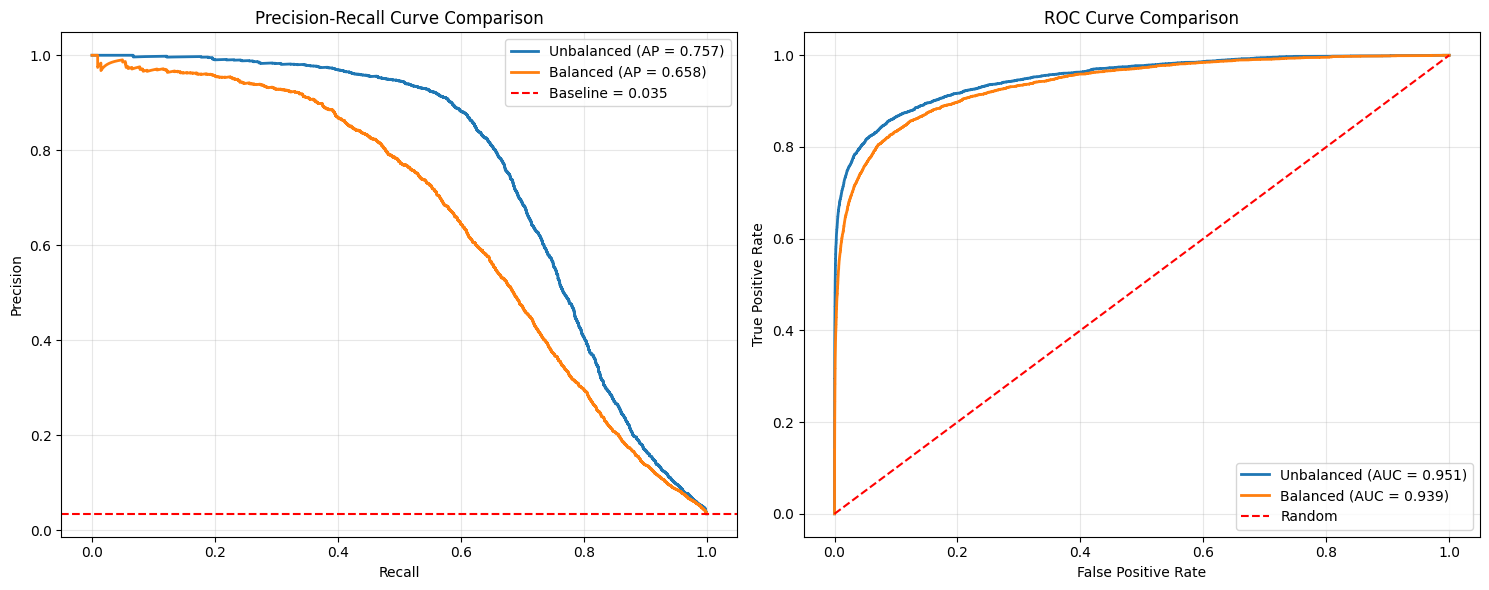

Spearman correlation between balanced and unbalanced predictions: 0.7586

=== FEATURE IMPORTANCE (BALANCED MODEL) ===
Top 20 most important features:
   1. V94            : 0.0647
   2. V258           : 0.0491
   3. V294           : 0.0392
   4. V280           : 0.0371
   5. V91            : 0.0366
   6. V327           : 0.0303
   7. V201           : 0.0286
   8. V70            : 0.0237
   9. V74            : 0.0227
  10. C8             : 0.0203
  11. V308           : 0.0179
  12. C14            : 0.0155
  13. card1          : 0.0147
  14. card2          : 0.0143
  15. V29            : 0.0136
  16. V34            : 0.0122
  17. V317           : 0.0112
  18. V283           : 0.0108
  19. V102           : 0.0106
  20. V335           : 0.0100

=== FINAL SUMMARY ===
XGBoost-Only Performance:
  Unbalanced - AUC: 0.9512, AP: 0.7572
  Balanced   - AUC: 0.9386, AP: 0.6578
  Improvement - AUC: -0.0125, AP: -0.0994


In [26]:
# 5. Model training
trainer = XGBoostTrainer(X_train, X_val, y_train, y_val)

# Train unbalanced model (baseline)
unbalanced_model = trainer.train_unbalanced_model(
    n_estimators=1000,
    learning_rate=0.03,
    early_stopping_rounds=50
)

# Train balanced model
balanced_model = trainer.train_balanced_model(
    sample_weights=sample_weights,
    scale_pos_weight=scale_pos_weight,
    n_estimators=1000,
    learning_rate=0.03,
    early_stopping_rounds=50,
    use_sample_weights=True,
    use_scale_pos_weight=True
)

# 6. Model evaluation
unbalanced_metrics = trainer.evaluate_model('unbalanced')
balanced_metrics = trainer.evaluate_model('balanced')

# 7. Comparison
compare_balanced_vs_unbalanced(
    X_val, y_val,
    balanced_model=balanced_model,
    unbalanced_model=unbalanced_model
)

# 8. Feature importance analysis (top 20)
print("\n=== FEATURE IMPORTANCE (BALANCED MODEL) ===")
feature_importance = balanced_model.feature_importances_
feature_names = pipeline.feature_names

# Get top 20 features
top_indices = np.argsort(feature_importance)[-20:]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

print("Top 20 most important features:")
for i, (feature, importance) in enumerate(zip(reversed(top_features), reversed(top_importance))):
    print(f"  {i+1:2d}. {feature:15s}: {importance:.4f}")

print("\n=== FINAL SUMMARY ===")
print("XGBoost-Only Performance:")
print(f"  Unbalanced - AUC: {unbalanced_metrics['auc']:.4f}, AP: {unbalanced_metrics['average_precision']:.4f}")
print(f"  Balanced   - AUC: {balanced_metrics['auc']:.4f}, AP: {balanced_metrics['average_precision']:.4f}")

improvement_auc = balanced_metrics['auc'] - unbalanced_metrics['auc']
improvement_ap = balanced_metrics['average_precision'] - unbalanced_metrics['average_precision']
print(f"  Improvement - AUC: {improvement_auc:+.4f}, AP: {improvement_ap:+.4f}")



=== TRAINING BALANCED XGBOOST MODEL ===
Using scale_pos_weight: 27.58
{'n_estimators': 1000, 'objective': 'binary:logistic', 'max_depth': 6, 'max_leaves': None, 'max_bin': None, 'grow_policy': None, 'learning_rate': 0.03, 'verbosity': 0, 'booster': None, 'tree_method': 'hist', 'gamma': None, 'min_child_weight': None, 'max_delta_step': None, 'subsample': 0.8, 'sampling_method': None, 'colsample_bytree': 0.8, 'colsample_bylevel': None, 'colsample_bynode': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': 27.580278281911674, 'base_score': None, 'missing': nan, 'num_parallel_tree': None, 'random_state': 42, 'n_jobs': -1, 'monotone_constraints': None, 'interaction_constraints': None, 'importance_type': None, 'device': 'cuda', 'validate_parameters': None, 'enable_categorical': True, 'feature_types': None, 'feature_weights': None, 'max_cat_to_onehot': None, 'max_cat_threshold': None, 'multi_strategy': None, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'callbacks': None

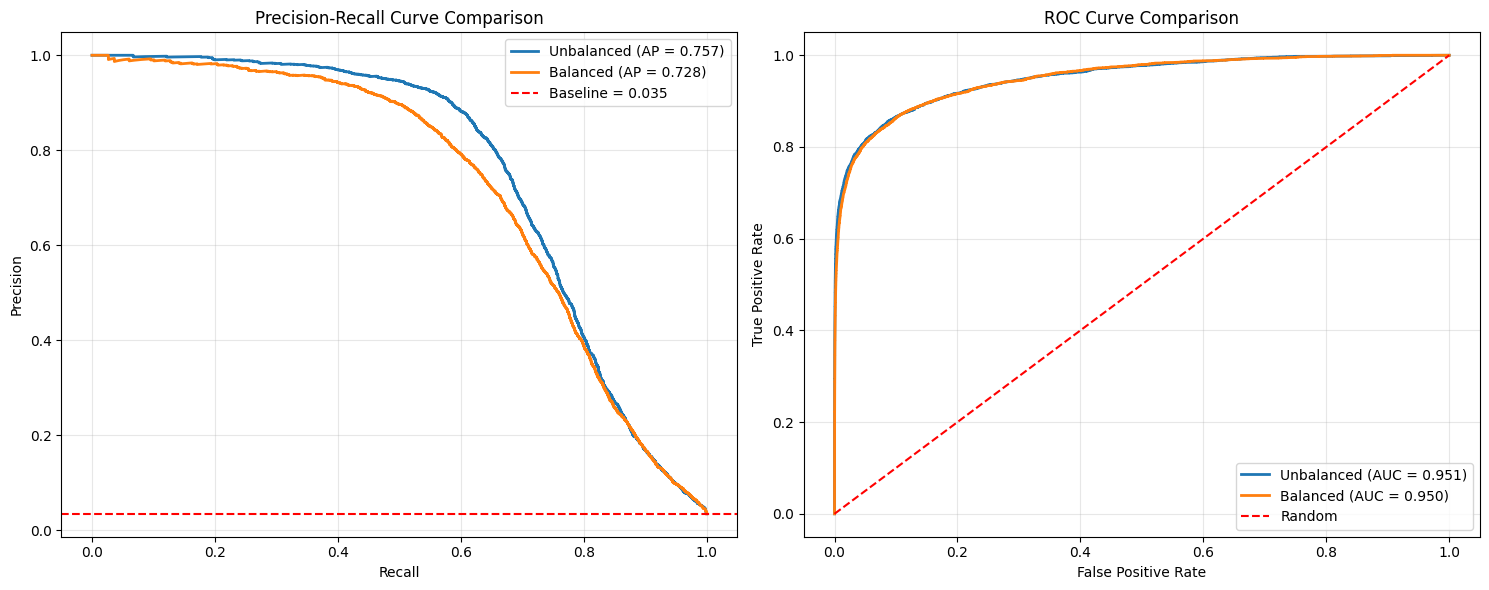

Spearman correlation between balanced and unbalanced predictions: 0.8124


{'unbalanced': {'auc': np.float64(0.9511826928991383),
  'ap': np.float64(0.7571953096117272)},
 'balanced': {'auc': np.float64(0.950272334969736),
  'ap': np.float64(0.7276096543330351)}}

In [27]:
# Only Scale Pos Weight
balanced_model = trainer.train_balanced_model(
    sample_weights=sample_weights,
    scale_pos_weight=scale_pos_weight,
    n_estimators=1000,
    learning_rate=0.03,
    early_stopping_rounds=50,
    use_sample_weights=False,
    use_scale_pos_weight=True
)

compare_balanced_vs_unbalanced(
    X_val, y_val,
    balanced_model=balanced_model,
    unbalanced_model=unbalanced_model
)


=== TRAINING BALANCED XGBOOST MODEL ===
{'n_estimators': 1000, 'objective': 'binary:logistic', 'max_depth': 6, 'max_leaves': None, 'max_bin': None, 'grow_policy': None, 'learning_rate': 0.03, 'verbosity': 0, 'booster': None, 'tree_method': 'hist', 'gamma': None, 'min_child_weight': None, 'max_delta_step': None, 'subsample': 0.8, 'sampling_method': None, 'colsample_bytree': 0.8, 'colsample_bylevel': None, 'colsample_bynode': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'base_score': None, 'missing': nan, 'num_parallel_tree': None, 'random_state': 42, 'n_jobs': -1, 'monotone_constraints': None, 'interaction_constraints': None, 'importance_type': None, 'device': 'cuda', 'validate_parameters': None, 'enable_categorical': True, 'feature_types': None, 'feature_weights': None, 'max_cat_to_onehot': None, 'max_cat_threshold': None, 'multi_strategy': None, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'callbacks': None}
Using sample weights (fraud samples weight

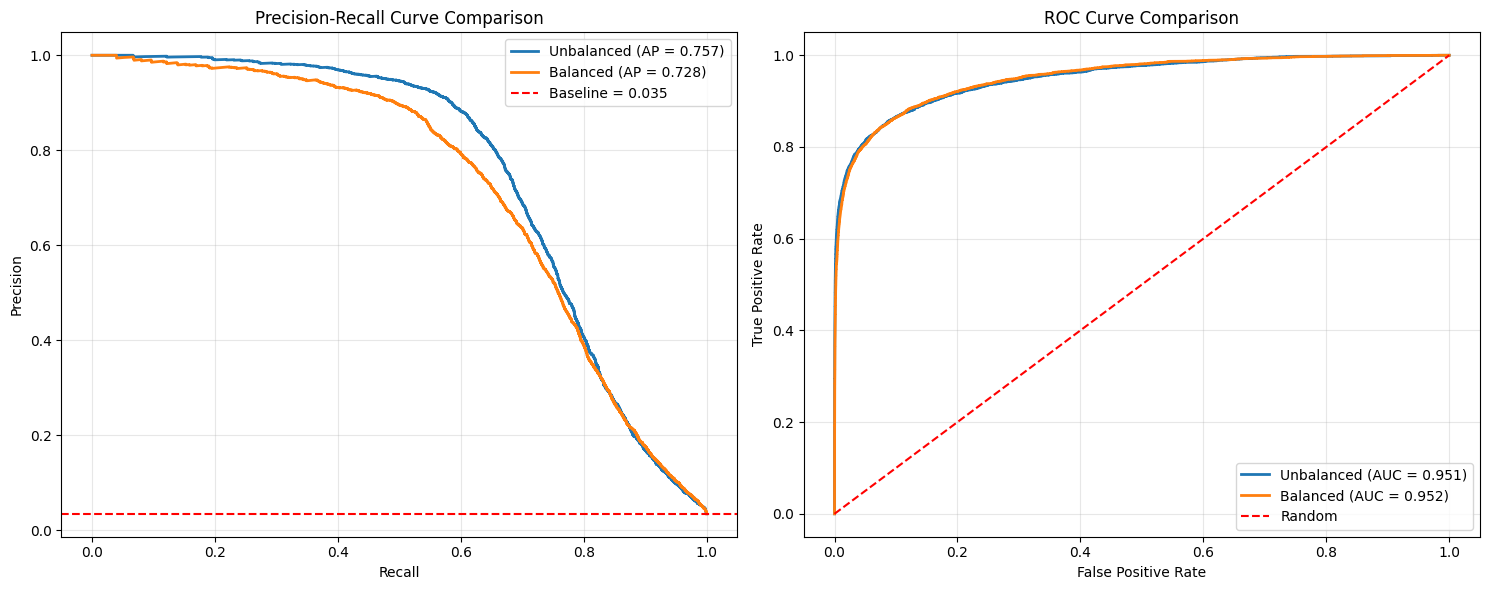

Spearman correlation between balanced and unbalanced predictions: 0.8429


{'unbalanced': {'auc': np.float64(0.9511826928991383),
  'ap': np.float64(0.7571953096117272)},
 'balanced': {'auc': np.float64(0.9518423750501994),
  'ap': np.float64(0.7275168064654309)}}

In [28]:
# Only Scale Pos Weight
balanced_model = trainer.train_balanced_model(
    sample_weights=sample_weights,
    scale_pos_weight=scale_pos_weight,
    n_estimators=1000,
    learning_rate=0.03,
    early_stopping_rounds=50,
    use_sample_weights=True,
    use_scale_pos_weight=False
)

compare_balanced_vs_unbalanced(
    X_val, y_val,
    balanced_model=balanced_model,
    unbalanced_model=unbalanced_model
)